
# Brewery Analysis: Machine Learning



---



*  Data is preprocessed and cleaned by removing unneeded columns, merging zip code/cities datasets, and limiting dataset to the top 1,000 most populated cities.
*  To obtain the best possible predictive results, preliminary features should be explored, engineered, and carefully selected. Possible preliminary features for this model could be average income per zipcode, income per capita, and clothing stores per brewery count.
*  The importance of correlation between breweries and outdoor clothing stores will drive which features will be engineered and selected, ultimately answering the hypthesis.
*  Data was split into training and testing sets using train_test_split and a random state of 24. This will assist in evaluating the performance of the model in relation to the dataset.
*  A linear regression model was chosen to best illustrate correlation between brewery location and outdoor clothing store location. Is there a strong relationship between the two? The benefits of using a linear regression is readability and abiility to answer basic questions. Limitations of a linear regression model will be sensitivity to outliers. With more time we would like to also set up a cluster model.





In [1]:
# Import dependencies

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from database_connection import ENGINE

**# Test Linear Regression Model**

In [2]:

X, y = make_regression(n_samples=100, n_features=1, random_state=24, noise=20, bias=50.0)

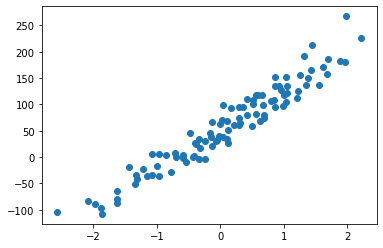

In [3]:
plt.scatter(X, y)

In [4]:
model = LinearRegression()
model

LinearRegression()

In [5]:
model.fit(X, y)
print(model)

LinearRegression()


In [6]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 

Weight coefficients:  [73.68622249]
y-axis intercept:  52.35050319965709


In [7]:
predictions = model.predict(X)
print(f"True output: {y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y[0]}")

True output: 51.573180999075355
Predicted output: 61.05269396989403
Prediction Error: 9.479512970818675


In [8]:
pd.DataFrame({"Predicted": predictions, "Actual": y, "Error": predictions - y})[["Predicted", "Actual", "Error"]]

,Predicted,Actual,Error
0,61.052694,51.573181,9.479513
1,116.539022,135.744467,-19.205445
2,-45.354712,-34.665692,-10.689020
3,-19.366764,6.805878,-26.172642
4,120.974797,134.426874,-13.452077
...,...,...,...
95,111.587291,106.903818,4.683473
96,96.719525,118.261070,-21.541545
97,191.563874,181.988316,9.575558
98,21.512531,3.015834,18.496697


# Data Selection

In [9]:
# Connect to needed databases 
# Connect to zip codes - cleaned database

zip_codes_cleaned_query = '''
    SELECT *
    FROM zip_codes_cleaned
'''

zip_codes = pd.read_sql_query(
    zip_codes_cleaned_query,
    con=ENGINE
)
# Connect to breweries database

breweries_query = '''
    SELECT *
    FROM breweries
'''

breweries = pd.read_sql_query(
    breweries_query,
    con=ENGINE
)

# Connect to outdoor clothing database

outdoor_query = '''
    SELECT *
    FROM outdoor
'''

outdoor = pd.read_sql_query(
    outdoor_query,
    con=ENGINE
)

In [10]:
zip_codes.sample(10)

,zip_code,city,state,county,latitude,longitude,irs_estimated_population
14861,49412,Fremont,MI,Newaygo County,43.46,-85.95,10310
9907,33786,Belleair Beach,FL,Pinellas County,27.91,-82.84,1450
5082,18101,Allentown,PA,Lehigh County,40.60,-75.47,3330
29710,99320,Benton City,WA,Benton County,46.24,-119.49,9060
23462,74146,Tulsa,OK,Tulsa County,36.10,-95.86,12790
24807,78160,Stockdale,TX,Wilson County,29.23,-97.96,3950
27628,92338,Ludlow,CA,San Bernardino County,34.72,-116.15,0
22904,72561,Mount Pleasant,AR,Izard County,35.98,-91.77,660
27061,89074,Henderson,NV,Clark County,36.03,-115.07,47190
5365,19111,Philadelphia,PA,Philadelphia County,40.06,-75.07,54800


In [11]:
# Remove yelp id and closed columns from outdoor/brewery dataframe

breweries_df = breweries.drop(['yelp_id', 'is_closed'], axis=1)
outdoor_df = outdoor.drop(['yelp_id', 'is_closed'], axis=1)

In [12]:
breweries_df=breweries_df.rename(columns={"name": "brewery", "rating": "brewery_rating"})

In [13]:
breweries_df.sample(10)

,brewery,lat,lng,original_search_city,yelp_city,business_type,brewery_rating,zip_code,state
244,3rd Turn Brewing,38.193110,-85.566560,Louisville,Louisville,breweries,4.5,40299,KY
402,The Tap At 1918,35.958530,-77.802080,Goldsboro,Rocky Mount,newamerican,4.0,27804,NC
419,Unidentified Flying Chickens,40.746559,-73.894037,Elmhurst,Jackson Heights,korean,3.5,11372,NY
27,Cooper's Mill,39.016280,-77.103930,Bethesda,Bethesda,newamerican,3.5,20814,MD
351,NOLA Brewing,29.919980,-90.081360,Houma,New Orleans,breweries,4.0,70115,LA
353,Oak St Brewery,29.948360,-90.130630,Houma,New Orleans,breweries,4.5,70118,LA
63,The Grape & Grain,47.938440,-122.218940,Everett,Everett,beer_and_wine,5.0,98203,WA
154,101 Beer Kitchen,40.051777,-82.864637,Westerville,Gahanna,gastropubs,4.5,43230,OH
89,Stunt Brewing,42.087809,-87.797294,Des Plaines,Glenview,breweries,4.5,60025,IL
9,Table 41 Brewing,42.771550,-73.700960,Albany,Cohoes,breweries,4.5,12047,NY


In [14]:
outdoor_df=outdoor_df.rename(columns={"name": "outdoor_store", "rating": "outdoor_rating"})

In [15]:
outdoor_df.sample(10)

,outdoor_store,lat,lng,original_search_city,yelp_city,business_type,outdoor_rating,zip_code,state
389,DICK'S Sporting Goods,42.662400,-83.136300,Rochester,Rochester Hills,outdoorgear,2.0,48307,MI
103,Nazzal Store,40.759250,-74.043510,Jersey City,Union City,sportswear,5.0,7087,NJ
33,OC Outdoors,33.672527,-117.918559,Irvine,Costa Mesa,guns_and_ammo,4.5,92626,CA
403,Moosejaw Bike & Snow,42.546768,-83.216931,Rochester,Birmingham,bikes,5.0,48009,MI
115,Burton Flagship -- New York City,40.723370,-74.001050,Jersey City,New York,skishops,4.5,10012,NY
300,Academy Sports + Outdoors,29.915616,-90.049643,Houma,Gretna,shoes,3.0,70053,LA
195,RUBBER N' ROAD,40.765086,-73.991075,Union City,New York,coffee,5.0,10019,NY
377,Sun Valley Sports Indy,39.706580,-86.068070,Columbus,Indianapolis,outdoorgear,3.0,46203,IN
314,West Marine,30.004950,-90.104920,Houma,New Orleans,boating,3.5,70124,LA
150,Grey Man Armory,30.637333,-87.043437,Pensacola,Milton,guns_and_ammo,3.0,32570,FL


In [16]:
# Connect to city_summary database
city_summary = '''
    SELECT *
    FROM city_summary
'''

city_summary_df = pd.read_sql_query(
    city_summary,
    con=ENGINE
)

city_summary_df.sample(10)

,city,state,mean_income,min_income,max_income,median_income,first_quartile_income,third_quartile_income,num_breweries,num_outdoor_stores,population,ts_updated
514,Loveland,OH,478127,78057,1311344,237236,196246,676037,0,0,53170,2022-08-22 05:28:06.714394+00:00
58,Beaumont,TX,79164,6400,714831,50872,28334,85776,0,0,105460,2022-08-22 05:28:06.714394+00:00
757,Rochester,MI,335934,31253,1588386,140185,70724,544017,1,19,96760,2022-08-22 05:28:06.714394+00:00
579,Mobile,AL,68070,2075,610010,47994,17118,82215,0,0,212623,2022-08-22 05:28:06.714394+00:00
41,Augusta,GA,133955,8020,532445,89993,26715,196782,0,0,158640,2022-08-22 05:28:06.714394+00:00
829,Scottsdale,AZ,365571,10088,4714919,137526,45211,245785,0,0,252530,2022-08-22 05:28:06.714394+00:00
155,Charlottesville,VA,283621,24730,1227425,130774,86172,313524,0,0,95939,2022-08-22 05:28:06.714394+00:00
983,Winter Park,FL,404510,37760,2712811,190176,87195,292738,0,0,62100,2022-08-22 05:28:06.714394+00:00
115,Buford,GA,293165,95180,583840,205004,196436,456388,0,0,99110,2022-08-22 05:28:06.714394+00:00
803,San Francisco,CA,497790,2354,4551004,147734,50580,405965,0,0,733090,2022-08-22 05:28:06.714394+00:00


In [17]:
# sort by num_breweries and top 25 because rest of cities has not been filled yet
# This can be removed once rest of cities have been filled
city_summary_top25 = city_summary_df.sort_values(by='num_breweries', ascending=False).head(25)
city_summary_top25

,city,state,mean_income,min_income,max_income,median_income,first_quartile_income,third_quartile_income,num_breweries,num_outdoor_stores,population,ts_updated
512,Louisville,KY,139141,1426,1223918,86366,42768,161692,18,12,648720,2022-08-22 05:28:06.714394+00:00
239,Des Plaines,IL,240090,61766,624247,221871,140416,293728,16,18,87190,2022-08-22 05:28:06.714394+00:00
728,Quincy,MA,217650,33467,738266,126500,98431,303616,15,18,85600,2022-08-22 05:28:06.714394+00:00
342,Goldsboro,NC,143490,76342,331255,120646,99310,165655,15,20,58075,2022-08-22 05:28:06.714394+00:00
136,Carson,CA,212034,55212,507431,160977,132312,287227,14,18,79570,2022-08-22 05:28:06.714394+00:00
138,Cartersville,GA,145371,51676,320527,124262,88690,170632,14,18,57430,2022-08-22 05:28:06.714394+00:00
411,Irvine,CA,312892,13881,2019877,113514,68676,360017,13,17,236760,2022-08-22 05:28:06.714394+00:00
530,Manassas,VA,223664,33707,672266,185866,92404,276335,12,16,146210,2022-08-22 05:28:06.714394+00:00
688,Pensacola,FL,113254,2300,546477,95842,43815,165592,12,12,220700,2022-08-22 05:28:06.714394+00:00
890,Tempe,AZ,237575,23927,919679,212583,128718,288195,11,18,129510,2022-08-22 05:28:06.714394+00:00


# Data Processing

In [18]:
# Set X and y for linear regression model
X = city_summary_top25.num_breweries.values.reshape(-1,1)
y = city_summary_top25.num_outdoor_stores.values.reshape(-1,1)
print(X.shape)
print(y.shape)

(25, 1)
(25, 1)


# Data Transformation

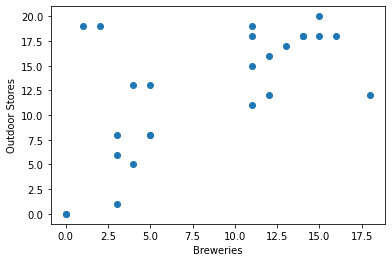

In [19]:
plt.scatter(city_summary_top25.num_breweries, city_summary_top25.num_outdoor_stores)
plt.xlabel('Breweries')
plt.ylabel('Outdoor Stores')
plt.show()

In [20]:
# Create an instance of the model(LinearRegression)
model = LinearRegression()

In [21]:
# Train the model with the dataset 
model.fit(X,y)

LinearRegression()

In [22]:
# r squared value of the model
model.score(X,y)

0.4017175530767336

In [23]:
y_pred = model.predict(X)

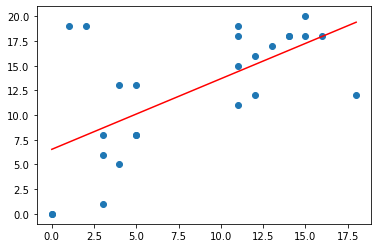

In [24]:
# Visualize trendline
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [25]:
# Find model slope and intercept
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 

Weight coefficients:  [[0.71445608]]
y-axis intercept:  [6.5357254]


In [26]:
# Model formula
print(f"y = {model.coef_[0][0]}x + {model.intercept_[0]}")

y = 0.7144560821321165x + 6.535725396660791


In [27]:
# Find Accuracy of predictions
predictions = model.predict(X)
print(f"True output: {y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y[0]}")

True output: [12]
Predicted output: [19.39593488]
Prediction Error: [7.39593488]


In [28]:
predictions_df = pd.DataFrame({"Predicted": predictions, "Actual": y, "Error": predictions - y})[["Predicted", "Actual", "Error"]]

ValueError: If using all scalar values, you must pass an index

# Multiple Linear Regression

In [29]:
# Remove categorical inputs that are not needed for this model
mlr_city_summary = city_summary_top25.drop(columns = ["city","state","ts_updated"])
mlr_city_summary.head()

,mean_income,min_income,max_income,median_income,first_quartile_income,third_quartile_income,num_breweries,num_outdoor_stores,population
512,139141,1426,1223918,86366,42768,161692,18,12,648720
239,240090,61766,624247,221871,140416,293728,16,18,87190
728,217650,33467,738266,126500,98431,303616,15,18,85600
342,143490,76342,331255,120646,99310,165655,15,20,58075
136,212034,55212,507431,160977,132312,287227,14,18,79570


In [30]:
# Get column names to be used when creating scaled df
mlr_city_summary_columns = mlr_city_summary.columns
mlr_city_summary_columns

Index(['mean_income', 'min_income', 'max_income', 'median_income',
       'first_quartile_income', 'third_quartile_income', 'num_breweries',
       'num_outdoor_stores', 'population'],
      dtype='object')

In [31]:
# Get column names without num_outdoor_stores to be used in ColumnTransformer function
summary_columns_no_outdoor = mlr_city_summary.columns.drop("num_outdoor_stores")
summary_columns_no_outdoor

Index(['mean_income', 'min_income', 'max_income', 'median_income',
       'first_quartile_income', 'third_quartile_income', 'num_breweries',
       'population'],
      dtype='object')

In [32]:
# Column names for use in making city_summary_scaled_df 
# Since ColumnTransformer function flipped the population and num_outdoor_stores columns, this is reflected in the column names
columns = ['mean_income', 'min_income', 'max_income', 'median_income',
       'first_quartile_income', 'third_quartile_income', 'num_breweries', 
           'population', 'num_outdoor_stores']

In [33]:
# Scale data using StandardScaler and ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# features is the dataframe being passed into the ColumnTransformer function
features = mlr_city_summary

# ColumnTransformer applys the StandardScaler Function to all columns in the summary_columns_no_outdoor list, 
# and passes over any others(num_outdoor_stores)
ct = ColumnTransformer([
        ('data_scaler', StandardScaler(), summary_columns_no_outdoor)
    ], remainder='passthrough')

city_summary_scaled = ct.fit_transform(features)

In [34]:
# Create new dataframe with the scaled data, leaving the num_outdoor_stores not scaled since it is out output
city_summary_scaled_df = pd.DataFrame(city_summary_scaled, columns = columns)
city_summary_scaled_df.head()

,mean_income,min_income,max_income,median_income,first_quartile_income,third_quartile_income,num_breweries,population,num_outdoor_stores
0,-0.667556,-1.072347,0.323211,-0.855866,-0.897734,-0.801286,1.742586,4.330859,12.0
1,0.202536,0.868569,-0.324622,1.013106,0.916156,0.263856,1.382548,-0.378224,18.0
2,0.009123,-0.041706,-0.201446,-0.302312,0.136251,0.343623,1.202529,-0.391558,18.0
3,-0.630072,1.337425,-0.641146,-0.383054,0.152579,-0.769316,1.202529,-0.622388,20.0
4,-0.039282,0.657751,-0.450820,0.173217,0.765617,0.211412,1.022509,-0.442127,18.0


In [35]:
# Set X and y for model
X = city_summary_scaled_df.drop(columns = "num_outdoor_stores")
y = city_summary_scaled_df["num_outdoor_stores"]

In [36]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =27)

In [37]:
# Create an object of LinearRegression class
lr = LinearRegression()

# fitting the training data
lr.fit(X_train,y_train)

LinearRegression()

In [38]:
# Get predictions
y_pred = lr.predict(X_test)
y_pred

array([ 6.70111414,  2.6943444 , 16.36476065, -2.78090006, 12.99480278,
       13.17793712, 11.69135255])

In [39]:
# Display the predicted vs actual values for number of outdoor stores
error_df = pd.DataFrame({"Predicted": y_pred, "Actual": y_test, "Error": y_pred - y_test})[["Predicted", "Actual", "Error"]]
error_df

,Predicted,Actual,Error
20,6.701114,6.0,0.701114
23,2.694344,0.0,2.694344
7,16.364761,16.0,0.364761
18,-2.780900,1.0,-3.780900
11,12.994803,19.0,-6.005197
12,13.177937,11.0,2.177937
9,11.691353,18.0,-6.308647


In [40]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_pred)
print(f'r2 score is {score}')
print(f'mean_sqrd_error is {mean_squared_error(y_test,y_pred)}')
print(f'root_mean_squared error is {np.sqrt(mean_squared_error(y_test,y_pred))}')

r2 score is 0.7286994673658351
mean_sqrd_error is 14.68344923562868
root_mean_squared error is 3.83189890728196


In [42]:
# Find impact of different variables
lr.coef_

array([ 3.22231813,  1.42628222, -5.10012635, -1.00021435, -3.66938223,
        3.38507728,  4.55249874, -0.65387877])

In [43]:
# Find the intercept
lr.intercept_

12.07373646351203